### 1. Setting Up Python Environment

In [1]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [2]:
%%capture
# Install PyTorch with CUDA
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Install additional dependencies
!pip install matplotlib pandas pillow torchtnt==0.2.0 tqdm tabulate

# Install package for creating visually distinct colormaps
!pip install distinctipy

#Install utility packages
!pip install cjm_pandas_utils cjm_psl_utils cjm_pil_utils cjm_pytorch_utils cjm_torchvision_tfms

In [3]:

import os
import json
import math
import random
import datetime
from glob import glob
from pathlib import Path
from functools import partial
import multiprocessing
from typing import Any, Dict, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from tqdm.auto import tqdm

import torch
from torch.amp import autocast
from torch.cuda.amp import GradScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms.v2 as transforms
from torchvision.transforms.v2 import functional as TF
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

from cjm_psl_utils.core import download_file, file_extract, get_source_code
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import (
    pil_to_tensor,
    tensor_to_pil,
    get_torch_device,
    set_seed,
    denorm_img_tensor,
    move_data_to_device
)
from cjm_pandas_utils.core import markdown_to_pandas, convert_to_numeric, convert_to_string
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

from distinctipy import distinctipy

from torchvision.models.detection import (
    maskrcnn_resnet50_fpn_v2,
    MaskRCNN,
    MaskRCNN_ResNet50_FPN_V2_Weights
)
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Disable beta‐transforms warning
torchvision.disable_beta_transforms_warning()

# Pandas display options
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Device & dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float32


### 2. Prepare Dataset: Spectrograms + LabelMe JSON

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
!cp "/content/drive/MyDrive/Colab Notebooks/dataset.py" .

In [6]:
from dataset import SpectrogramDataset, move_data_to_device, collate_fn

In [7]:
SPECT_DIR = Path('/content/drive/MyDrive/Colab Notebooks/spectrograms')

# Verify it works
print("Found PNGs:", len(list(SPECT_DIR.rglob('*.png'))))
print("Found JSONs:", len(list(SPECT_DIR.rglob('*.json'))))


Found PNGs: 360
Found JSONs: 360


In [8]:
png_files = list(SPECT_DIR.rglob('*.png'))
img_dict  = {p.stem: str(p) for p in png_files}

records = []
for jp in SPECT_DIR.rglob('*.json'):
    data = json.load(open(jp))
    records.append({
        'image_id': jp.stem,
        'shapes':    data.get('shapes', [])
    })

annotation_df = (
    pd.DataFrame.from_records(records)
      .set_index('image_id')
      .loc[lambda df: df.index.intersection(img_dict.keys())]
)

print(f"Found {len(img_dict)} images and {len(annotation_df)} annotations")
annotation_df.head()

Found 360 images and 360 annotations


,shapes
image_id,
1-18527-A-44,"[{'label': 'engine', 'points': [[2.2426470588235397, 51.79411764705884], [307.75735294117646, 52.89705882352943], [307.75735294117646, 306.94117647058823], [1.875000000000007, 306.94117647058823]], 'group_id': None, 'description': '', 'shape_type': 'polygon', 'flags': {}, 'mask': None}]"
1-18527-B-44,"[{'label': 'engine', 'points': [[1.5073529411764781, 62.08823529411766], [308.860294117647, 60.98529411764707], [308.860294117647, 307.0], [0.7720588235294201, 306.94117647058823]], 'group_id': None, 'description': '', 'shape_type': 'polygon', 'flags': {}, 'mask': None}]"
1-22882-A-44,"[{'label': 'engine', 'points': [[1.875000000000007, 36.35294117647061], [309.0, 35.2521347248577], [308.49390689246303, 307.00000000000006], [0.7720588235294201, 306.94117647058823]], 'group_id': None, 'description': '', 'shape_type': 'polygon', 'flags': {}, 'mask': None}]"
1-50454-A-44,"[{'label': 'engine', 'points': [[3.2426470588235716, 36.352941176470594], [166.9485294117647, 36.72058823529412], [170.25735294117646, 307.0], [2.1397058823529846, 306.94117647058835]], 'group_id': None, 'description': '', 'shape_type': 'polygon', 'flags': {}, 'mask': None}]"
1-50455-A-44,"[{'label': 'engine', 'points': [[3.2426470588235716, 36.352941176470594], [180.91911764705884, 35.61764705882354], [184.5955882352941, 306.94117647058823], [2.1397058823529846, 306.94117647058835]], 'group_id': None, 'description': '', 'shape_type': 'polygon', 'flags': {}, 'mask': None}]"


In [9]:
 # class names and mapping
all_labels = annotation_df['shapes'].explode().dropna().apply(lambda s: s['label'])
class_names = ['background'] + sorted(all_labels.unique().tolist())
class_to_idx = {c: i for i, c in enumerate(class_names)}

# check if all labels are presented successfully
pd.DataFrame(class_names, columns=['class_name'])


,class_name
0,background
1,airplane
2,car-horn
3,chainsaw
4,engine
5,fireworks
6,hand-saw
7,helicopter
8,siren
9,train


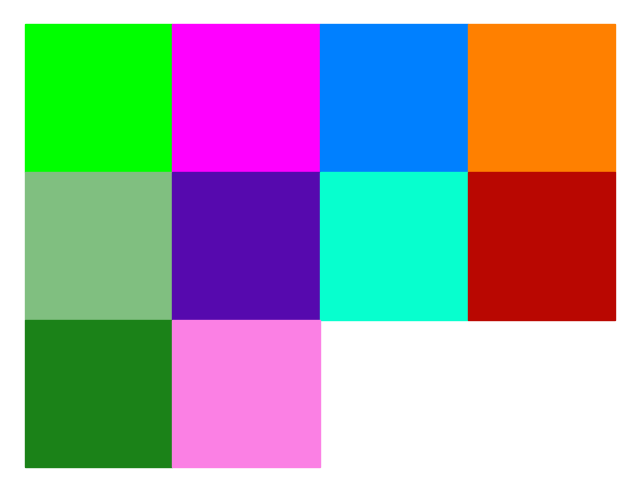

In [10]:
# Build & visualize a color map (include background)
colors     = distinctipy.get_colors(len(class_names))
int_colors = [tuple(int(c*255) for c in color) for color in colors]
distinctipy.color_swatch(colors)

In [11]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

  0%|          | 0.00/130k [00:00<?, ?iB/s]

In [12]:
# Split train/val
img_keys = annotation_df.index.tolist()
random.shuffle(img_keys)
split = int(0.8 * len(img_keys))
train_keys, val_keys = img_keys[:split], img_keys[split:]

print(f"Training on {len(train_keys)} samples, validating on {len(val_keys)} samples")

Training on 288 samples, validating on 72 samples


### 3. Dataset and Transforms

In [13]:
# Set training image size
train_sz = 512

# Create a RandomIoUCrop object
iou_crop = CustomRandomIoUCrop(
    min_scale=0.3, max_scale=1.0,
    min_aspect_ratio=0.5, max_aspect_ratio=2.0,
    sampler_options=[0.0,0.1,0.3,0.5,0.7,0.9,1.0],
    trials=400, jitter_factor=0.25
)
resize_max = ResizeMax(max_sz=train_sz)
pad_sq    = PadSquare(shift=True, fill=0)

# Data augmentation pipeline
data_aug = transforms.Compose([
    iou_crop,
    transforms.ColorJitter(
        brightness=(0.875, 1.125),
        contrast=(0.5, 1.5),
        saturation=(0.5, 1.5),
        hue=(-0.05, 0.05)
    ),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(p=0.5),
])

# Resize and pad pipeline
resize_pad = transforms.Compose([
    resize_max,
    pad_sq,
    transforms.Resize([train_sz, train_sz], antialias=True),
])

# Final normalization and bounding box sanitization
finalize = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.SanitizeBoundingBoxes(),
])

# Combined transforms
train_tfms = transforms.Compose([data_aug, resize_pad, finalize])
val_tfms   = transforms.Compose([resize_pad, finalize])


# Instantiate the datasets
train_ds = SpectrogramDataset(
    keys       = train_keys,
    df         = annotation_df,
    img_map    = img_dict,
    cls2idx    = class_to_idx,
    transforms = train_tfms
)
val_ds = SpectrogramDataset(
    keys       = val_keys,
    df         = annotation_df,
    img_map    = img_dict,
    cls2idx    = class_to_idx,
    transforms = val_tfms
)

print(f"Train samples: {len(train_ds)},  Val samples: {len(val_ds)}")

loader_params = {
    'batch_size': 4,
    'num_workers': multiprocessing.cpu_count()//2,
    'pin_memory': True,
    'persistent_workers': True,
    'collate_fn': collate_fn,
}

train_loader = DataLoader(train_ds, shuffle=True,  **loader_params)
val_loader   = DataLoader(val_ds,   shuffle=False, **loader_params)


print(f"Train batches: {len(train_loader)},  Val batches: {len(val_loader)}")


Train samples: 288,  Val samples: 72
Train batches: 72,  Val batches: 18


### Visualize a Sample Labeled Spectrogram

Image Dims: (310, 308)


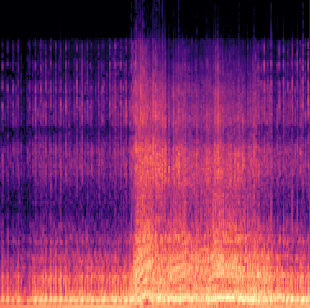

In [14]:
file_id    = list(img_dict.keys())[16]

# Load & show the spectrogram
sample_img = Image.open(img_dict[file_id]).convert('RGB')
print(f"Image Dims: {sample_img.size}")
display(sample_img)

## Inspect the corresponding annotation data

In [15]:
# Get the row from the 'annotation_df' DataFrame corresponding to the 'file_id'
annotation_df.loc[file_id].to_frame()

,3-115382-A-44
shapes,"[{'label': 'engine', 'points': [[0.0, 31.20588235294119], [309.0, 31.573529411764724], [309.0, 307.0], [0.0, 307.0]], 'group_id': None, 'description': '', 'shape_type': 'polygon', 'flags': {}, 'mask': None}]"


### Define a function to convert segmentation polygons to images

In [16]:
def create_polygon_mask(image_size, vertices):
    """
    Create a grayscale image with a white polygonal area on a black background.

    Parameters:
    - image_size (tuple): A tuple representing the dimensions (width, height) of the image.
    - vertices (list): A list of tuples, each containing the x, y coordinates of a vertex
                        of the polygon. Vertices should be in clockwise or counter-clockwise order.

    Returns:
    - PIL.Image.Image: A PIL Image object containing the polygonal mask.
    """

    # Create a new black image with the given dimensions
    mask_img = Image.new('L', image_size, 0)

    # Draw the polygon on the image. The area inside the polygon will be white (255).
    ImageDraw.Draw(mask_img, 'L').polygon(vertices, fill=(255))

    # Return the image with the drawn polygon
    return mask_img

### Annotate the sample image

In [17]:
draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2, font=font_file, font_size=25)

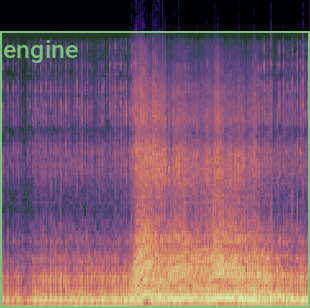

In [18]:
# Extract the labels for the sample
labels = [shape['label'] for shape in annotation_df.loc[file_id]['shapes']]

# Extract the polygon points for segmentation mask
shape_points = [shape['points'] for shape in annotation_df.loc[file_id]['shapes']]

# Format polygon points for PIL
xy_coords = [[tuple(p) for p in points] for points in shape_points]
# Generate mask images from polygons
mask_imgs = [create_polygon_mask(sample_img.size, xy) for xy in xy_coords]
# Convert mask images to tensors
masks = torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs])
# Generate bounding box annotations from segmentation masks
bboxes = torchvision.ops.masks_to_boxes(masks)

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sample_img),
    masks=masks,
    alpha=0.3,
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor,
    boxes=bboxes,
    labels=labels,
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

tensor_to_pil(annotated_tensor)


### Load & Adapt MaskRCNN for Spectrogram

In [19]:
# Load COCO‐pretrained Mask R-CNN v2
weights = MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model   = maskrcnn_resnet50_fpn_v2(weights=weights)


num_classes = len(class_names) + 1  # background + my sound labels
# box predictor
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(
    in_channels=in_features_box,
    num_classes=num_classes
)
# mask predictor
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer    = model.roi_heads.mask_predictor.conv5_mask.out_channels
model.roi_heads.mask_predictor = MaskRCNNPredictor(
    in_channels=in_features_mask,
    dim_reduced=hidden_layer,
    num_classes=num_classes
)

# 4.3 Move to device & dtype
model.to(device=device, dtype=dtype)

print(f"✅ MaskRCNN ready with {num_classes-1} spectrogram classes (plus background)")


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:00<00:00, 218MB/s]


✅ MaskRCNN ready with 10 spectrogram classes (plus background)


### Fine-Tune the Model

In [20]:
def run_epoch(model, dataloader, optimizer, lr_scheduler, device, scaler, epoch_id, is_training):
    """
    Run one epoch (train or eval) and return the average loss.
    Always keep model.train() so forward() returns a dict of losses.
    """
    model.train()  # never call model.eval() here

    total_loss = 0.0
    pbar = tqdm(total=len(dataloader), desc="Train" if is_training else "Eval")

    for batch_id, (imgs, targets) in enumerate(dataloader):
        imgs = torch.stack(imgs).to(device)

        ## For training
        if is_training:
            with torch.cuda.amp.autocast():  # Remove device_type parameter
                losses = model(imgs, move_data_to_device(targets, device))
        else:
            with torch.no_grad(), torch.cuda.amp.autocast():  # Remove device_type parameter
                losses = model(imgs, move_data_to_device(targets, device))

        # sum all loss terms
        loss = sum(losses.values())

        # backward + step
        if is_training:
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                lr_scheduler.step()
                optimizer.zero_grad()
            else:
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

        # logging
        loss_item = loss.item()
        total_loss += loss_item
        stats = {
            "loss": loss_item,
            "avg": total_loss / (batch_id + 1)
        }
        if is_training:
            stats["lr"] = lr_scheduler.get_last_lr()[0]
        pbar.set_postfix(stats)
        pbar.update()

    pbar.close()
    return total_loss / len(dataloader)


def train_loop(model,
               train_dataloader,
               valid_dataloader,
               optimizer,
               lr_scheduler,
               device,
               epochs,
               checkpoint_path,
               use_scaler=False):
    """
    Full training+validation over `epochs`, saving best by val loss.
    """
    scaler = torch.cuda.amp.GradScaler() if (device.type == "cuda" and use_scaler) else None
    best_val = float("inf")

    for epoch in range(epochs):
        train_loss = run_epoch(
            model, train_dataloader, optimizer, lr_scheduler,
            device, scaler, epoch, is_training=True
        )
        valid_loss = run_epoch(
            model, valid_dataloader, optimizer=None, lr_scheduler=None,
            device=device, scaler=scaler, epoch_id=epoch, is_training=False
        )

        print(f"Epoch {epoch:02d}: Train {train_loss:.4f} | Val {valid_loss:.4f}")

        if valid_loss < best_val:
            best_val = valid_loss
            torch.save(model.state_dict(), checkpoint_path)
            # (optional) write out metadata here

    if device.type != "cpu":
        torch.cuda.empty_cache()


In [21]:
project_name = 'musa6950-final-modelcheck'
project_dir  = Path(f"./{project_name}/")
project_dir.mkdir(parents=True, exist_ok=True)

# give the model a name (used in the filename)
model.name = "urbansoundpollution-detection"

# timestamp folder
timestamp      = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
checkpoint_dir = project_dir / timestamp
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# full path to your .pth
checkpoint_path = checkpoint_dir / f"{model.name}.pth"
print("Checkpoints will be saved to:", checkpoint_path)

Checkpoints will be saved to: musa6950-final-modelcheck/2025-05-04_07-02-50/urbansoundpollution-detection.pth


In [22]:
# 6.1 Define optimizer & scheduler
lr = 5e-4
epochs = 40
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=lr,
    total_steps=epochs * len(train_loader)
)

# 6.2 Run training
train_loop(
    model            = model,
    train_dataloader = train_loader,
    valid_dataloader = val_loader,
    optimizer        = optimizer,
    lr_scheduler     = lr_scheduler,
    device           = device,
    epochs           = epochs,
    checkpoint_path  = checkpoint_path,
    use_scaler       = True
)


<ipython-input-20-5a9c67596401>:67: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if (device.type == "cuda" and use_scaler) else None


Train:   0%|          | 0/72 [00:00<?, ?it/s]

<ipython-input-20-5a9c67596401>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Remove device_type parameter
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  # Subclass instead of assign because we want __name__ of _LRScheduler to be _LRScheduler (assigning would make it LRScheduler).


Eval:   0%|          | 0/18 [00:00<?, ?it/s]

<ipython-input-20-5a9c67596401>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():  # Remove device_type parameter


Epoch 00: Train 1.2301 | Val 0.6646


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 01: Train 0.5323 | Val 0.3763


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 02: Train 0.3126 | Val 0.2566


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 03: Train 0.2396 | Val 0.2374


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 04: Train 0.2160 | Val 0.2185


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 05: Train 0.2060 | Val 0.2241


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 06: Train 0.2010 | Val 0.2521


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 07: Train 0.1904 | Val 0.2142


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 08: Train 0.2034 | Val 0.2215


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 09: Train 0.1983 | Val 0.1984


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10: Train 0.1759 | Val 0.2161


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11: Train 0.1861 | Val 0.2346


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12: Train 0.1807 | Val 0.2187


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13: Train 0.1827 | Val 0.2199


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14: Train 0.1669 | Val 0.2005


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15: Train 0.1723 | Val 0.1984


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16: Train 0.1546 | Val 0.2004


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17: Train 0.1461 | Val 0.2020


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18: Train 0.1448 | Val 0.1825


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19: Train 0.1545 | Val 0.1916


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20: Train 0.1639 | Val 0.1870


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 21: Train 0.1592 | Val 0.1814


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 22: Train 0.1442 | Val 0.1869


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 23: Train 0.1294 | Val 0.1727


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 24: Train 0.1304 | Val 0.2059


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 25: Train 0.1342 | Val 0.1694


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 26: Train 0.1163 | Val 0.1858


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 27: Train 0.1082 | Val 0.1713


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 28: Train 0.1171 | Val 0.1642


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 29: Train 0.1118 | Val 0.1577


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 30: Train 0.1012 | Val 0.1742


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 31: Train 0.1013 | Val 0.1867


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 32: Train 0.0907 | Val 0.1785


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 33: Train 0.0940 | Val 0.1677


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 34: Train 0.0897 | Val 0.1612


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 35: Train 0.0957 | Val 0.1627


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 36: Train 0.0859 | Val 0.1645


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 37: Train 0.0868 | Val 0.1608


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 38: Train 0.0817 | Val 0.1637


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 39: Train 0.0839 | Val 0.1580


<ipython-input-26-4fb3ac11f470>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if (device.type == "cuda" and use_scaler) else None


Train:   0%|          | 0/72 [00:00<?, ?it/s]

<ipython-input-20-5a9c67596401>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Remove device_type parameter


Eval:   0%|          | 0/18 [00:00<?, ?it/s]

<ipython-input-20-5a9c67596401>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():  # Remove device_type parameter


Epoch 00: Train 0.0889 | Val 0.1470


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 01: Train 0.0880 | Val 0.1700


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 02: Train 0.0904 | Val 0.1923


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 03: Train 0.1017 | Val 0.1803


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 04: Train 0.1206 | Val 0.1983


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 05: Train 0.1394 | Val 0.2011


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 06: Train 0.1423 | Val 0.1945


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 07: Train 0.1659 | Val 0.2170


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 08: Train 0.1822 | Val 0.2228


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 09: Train 0.1729 | Val 0.2321


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10: Train 0.1701 | Val 0.2212


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11: Train 0.1647 | Val 0.2004


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12: Train 0.1664 | Val 0.2139


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13: Train 0.1687 | Val 0.2176


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14: Train 0.1560 | Val 0.1945


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15: Train 0.1484 | Val 0.1984


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16: Train 0.1526 | Val 0.1798


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17: Train 0.1431 | Val 0.1907


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18: Train 0.1427 | Val 0.1836


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19: Train 0.1322 | Val 0.1929


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20: Train 0.1361 | Val 0.1828


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 21: Train 0.1426 | Val 0.1796


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 22: Train 0.1319 | Val 0.1939


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 23: Train 0.1281 | Val 0.1910


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 24: Train 0.1276 | Val 0.1978


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 25: Train 0.1213 | Val 0.1903


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 26: Train 0.1167 | Val 0.1724


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 27: Train 0.1114 | Val 0.1804


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 28: Train 0.1040 | Val 0.1857


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 29: Train 0.1089 | Val 0.1594


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 30: Train 0.0971 | Val 0.1677


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 31: Train 0.0974 | Val 0.1687


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 32: Train 0.0912 | Val 0.1648


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 33: Train 0.0885 | Val 0.1659


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 34: Train 0.0918 | Val 0.1635


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 35: Train 0.0857 | Val 0.1594


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 36: Train 0.0836 | Val 0.1620


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 37: Train 0.0791 | Val 0.1650


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 38: Train 0.0839 | Val 0.1651


Train:   0%|          | 0/72 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 39: Train 0.0838 | Val 0.1584


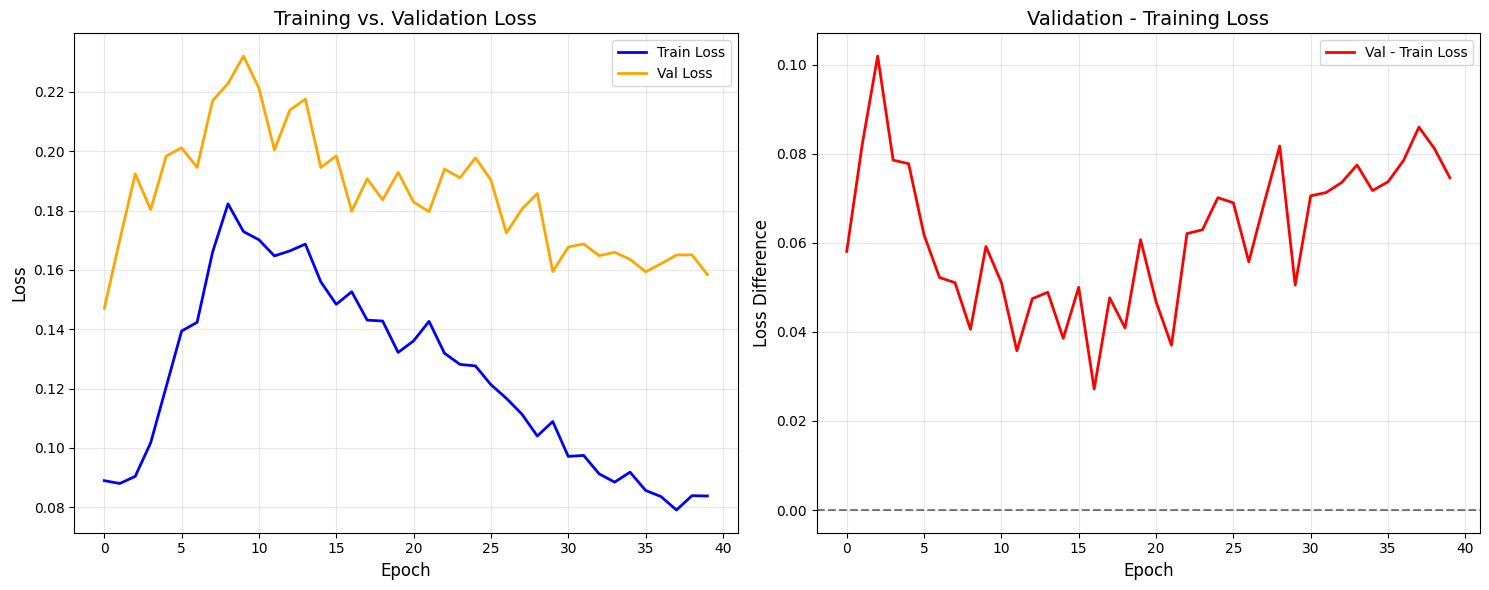


Training Summary:
Final Training Loss: 0.083785
Final Validation Loss: 0.158384
Best Validation Loss: 0.147019 (Epoch 0)
Final Loss Difference: 0.074599


In [26]:


# 1) Fixed train_loop to correctly return the loss histories
def train_loop(model,
               train_dataloader,
               valid_dataloader,
               optimizer,
               lr_scheduler,
               device,
               epochs,
               checkpoint_path,
               use_scaler=False):
    scaler = torch.cuda.amp.GradScaler() if (device.type == "cuda" and use_scaler) else None
    best_val = float("inf")
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        # Run training epoch
        train_loss = run_epoch(
            model, train_dataloader, optimizer, lr_scheduler,
            device, scaler, epoch, is_training=True
        )
        train_losses.append(train_loss)

        # Run validation epoch
        val_loss = run_epoch(
            model, valid_dataloader, optimizer=None, lr_scheduler=None,
            device=device, scaler=scaler, epoch_id=epoch, is_training=False
        )
        val_losses.append(val_loss)

        # Print progress (fixed f-string)
        print(f"Epoch {epoch:02d}: Train {train_loss:.4f} | Val {val_loss:.4f}")

        # Save best model
        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), checkpoint_path)

    if device.type != "cpu":
        torch.cuda.empty_cache()

    return train_losses, val_losses

# 2) Run training with the original parameters
lr = 5e-4
epochs = 40
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=lr,
    total_steps=epochs * len(train_loader)
)

# 3) Execute training and capture losses
train_losses, val_losses = train_loop(
    model            = model,
    train_dataloader = train_loader,
    valid_dataloader = val_loader,
    optimizer        = optimizer,
    lr_scheduler     = lr_scheduler,
    device           = device,
    epochs           = epochs,
    checkpoint_path  = checkpoint_path,
    use_scaler       = True
)

# 4) Create enhanced visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Training and Validation Loss
ax1.plot(train_losses, label="Train Loss", linewidth=2, color='blue')
ax1.plot(val_losses, label="Val Loss", linewidth=2, color='orange')
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Loss", fontsize=12)
ax1.set_title("Training vs. Validation Loss", fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Loss Difference and Overfitting Detection
loss_diff = [abs(val - train) for val, train in zip(val_losses, train_losses)]
ax2.plot(loss_diff, label="Val - Train Loss", linewidth=2, color='red')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("Loss Difference", fontsize=12)
ax2.set_title("Validation - Training Loss", fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5) Print summary statistics
print("\nTraining Summary:")
print(f"Final Training Loss: {train_losses[-1]:.6f}")
print(f"Final Validation Loss: {val_losses[-1]:.6f}")
print(f"Best Validation Loss: {min(val_losses):.6f} (Epoch {val_losses.index(min(val_losses))})")
print(f"Final Loss Difference: {abs(val_losses[-1] - train_losses[-1]):.6f}")

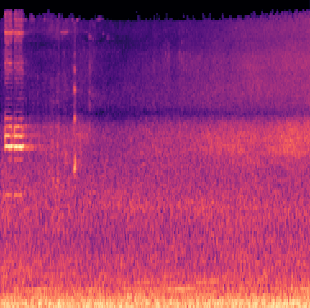

Source Image Size:,"(310, 308)"
Input Dims:,"(515, 512)"
Min Image Scale:,0.601562
Input Image Size:,"(515, 512)"


In [27]:
# Choose a random item from the validation set
file_id = random.choice(val_keys)

# Retrieve the image file path associated with the file ID
test_file = img_dict[file_id]

# Open the test file
test_img = Image.open(test_file).convert('RGB')

# Resize the test image
input_img = resize_img(test_img, target_sz=train_sz, divisor=1)

# Calculate the scale between the source image and the resized image
min_img_scale = min(test_img.size) / min(input_img.size)

display(test_img)

# Print the prediction data as a Pandas DataFrame for easy formatting
pd.Series({
    "Source Image Size:": test_img.size,
    "Input Dims:": input_img.size,
    "Min Image Scale:": min_img_scale,
    "Input Image Size:": input_img.size
}).to_frame().style.hide(axis='columns')


In [28]:
# Extract the polygon points for segmentation mask
target_shape_points = [shape['points'] for shape in annotation_df.loc[file_id]['shapes']]
# Format polygon points for PIL
target_xy_coords = [[tuple(p) for p in points] for points in target_shape_points]
# Generate mask images from polygons
target_mask_imgs = [create_polygon_mask(test_img.size, xy) for xy in target_xy_coords]
# Convert mask images to tensors
target_masks = Mask(torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in target_mask_imgs]))

# Get the target labels and bounding boxes
target_labels = [shape['label'] for shape in annotation_df.loc[file_id]['shapes']]
target_bboxes = BoundingBoxes(data=torchvision.ops.masks_to_boxes(target_masks), format='xyxy', canvas_size=test_img.size[::-1])

In [29]:
# Set the model to evaluation mode
model.eval();

# Ensure the model and input data are on the same device
model.to(device)
input_tensor = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])(input_img)[None].to(device)

# Make a prediction with the model
with torch.no_grad():
    model_output = model(input_tensor)

In [30]:
# Set the confidence threshold
threshold = 0.5

# Move model output to the CPU
model_output = move_data_to_device(model_output, 'cpu')

# Filter the output based on the confidence threshold
scores_mask = model_output[0]['scores'] > threshold

# Scale the predicted bounding boxes
pred_bboxes = BoundingBoxes(model_output[0]['boxes'][scores_mask]*min_img_scale, format='xyxy', canvas_size=input_img.size[::-1])

# Get the class names for the predicted label indices
pred_labels = [class_names[int(label)] for label in model_output[0]['labels'][scores_mask]]

# Extract the confidence scores
pred_scores = model_output[0]['scores']

# Scale and stack the predicted segmentation masks
pred_masks = F.interpolate(model_output[0]['masks'][scores_mask], size=test_img.size[::-1])
pred_masks = torch.concat([Mask(torch.where(mask >= threshold, 1, 0), dtype=torch.bool) for mask in pred_masks])

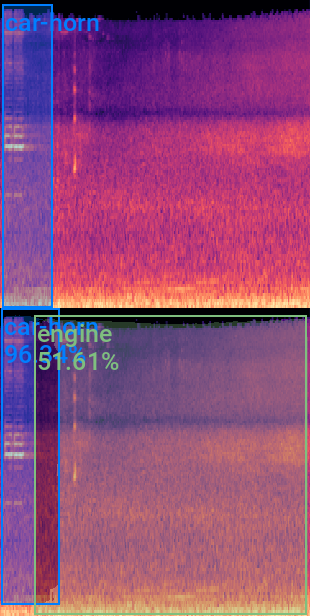

Target BBoxes:,['car-horn:[ 2. 4. 52. 307.]']
Predicted BBoxes:,"['car-horn:[ 1.431 0. 59.003 296.368]', 'engine:[ 34.14 7.337 306.888 306.386]']"
Confidence Scores:,"['car-horn: 96.34%', 'engine: 51.61%']"


In [31]:
# Get the annotation colors for the targets and predictions
target_colors=[int_colors[i] for i in [class_names.index(label) for label in target_labels]]
pred_colors=[int_colors[i] for i in [class_names.index(label) for label in pred_labels]]

# Convert the test images to a tensor
img_tensor = transforms.PILToTensor()(test_img)

# Annotate the test image with the target segmentation masks
annotated_tensor = draw_segmentation_masks(image=img_tensor, masks=target_masks, alpha=0.3, colors=target_colors)
# Annotate the test image with the target bounding boxes
annotated_tensor = draw_bboxes(image=annotated_tensor, boxes=target_bboxes, labels=target_labels, colors=target_colors)
# Display the annotated test image
annotated_test_img = tensor_to_pil(annotated_tensor)

# Annotate the test image with the predicted segmentation masks
annotated_tensor = draw_segmentation_masks(image=img_tensor, masks=pred_masks, alpha=0.3, colors=pred_colors)
# Annotate the test image with the predicted labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor,
    boxes=pred_bboxes,
    labels=[f"{label}\n{prob*100:.2f}%" for label, prob in zip(pred_labels, pred_scores)],
    colors=pred_colors
)

# Display the annotated test image with the predicted bounding boxes
display(stack_imgs([annotated_test_img, tensor_to_pil(annotated_tensor)]))

# Print the prediction data as a Pandas DataFrame for easy formatting
pd.Series({
    "Target BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(target_labels, np.round(target_bboxes.numpy(), decimals=3))],
    "Predicted BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(pred_labels, pred_bboxes.round(decimals=3).numpy())],
    "Confidence Scores:": [f"{label}: {prob*100:.2f}%" for label, prob in zip(pred_labels, pred_scores)]
}).to_frame().style.hide(axis='columns')